# Treinamento e Avaliação de modelo de machine learning para detecção de fake-news

O presente **(PI)** consiste em utilizar um conjunto de dados já pré-processado para aplicar técnicas de processamento de linguagem natural em um modelo de aprendizado de máquina, com o objetivo de detectar notícias falsas **(fake news)**.


De acordo com o treinamento e Avaliação o algoritmo que melhor se adaptou aos dados foi o DecisionTreeClassifier: CART: 0.881703 (0.013257)

- LR: 0.657755 (0.016475)
- LDA: 0.659827 (0.016238)
- KNN: 0.857253 (0.018251)
- CART: 0.881703 (0.013257)
- NB: 0.834052 (0.014550)
- SVM: 0.868238 (0.015367)


Árvore de Decisão
```
              precision    recall  f1-score   support

     VERDADE       0.87      0.86      0.87       605
       FALSO       0.86      0.87      0.87       602

    accuracy                           0.87      1207
   macro avg       0.87      0.87      0.87      1207
weighted avg       0.87      0.87      0.87      1207
```

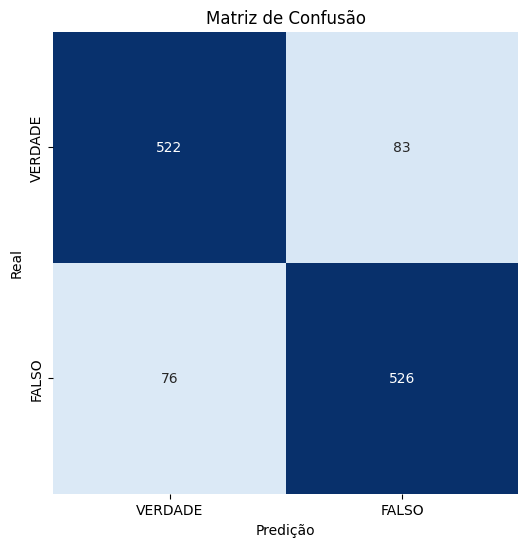



In [ ]:
!pip install psycopg2-binary
!pip install sqlalchemy psycopg2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 20.7 MB/s eta 0:00:00


In [ ]:
!pip install unidecode
!pip install imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 2.4 MB/s eta 0:00:00


In [ ]:
import psycopg2

def create_conn():
    conn = psycopg2.connect(
        host="monorail.proxy.rlwy.net",
        database="railway",
        user="postgres",
        port = 33482,
        password="dfXFikymJcYDSjzLfAAPvJIQeOQKvCjD")

    return conn

# Use a conexão
conn = create_conn()
cur = conn.cursor()

## Carregando os dados

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

# importando bibliotecas
from unidecode import unidecode
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.util import ngrams
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.svm import SVC
from pandas.plotting import scatter_matrix
from statistics import mean
from imblearn.over_sampling import RandomOverSampler
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import model_selection


# nltk.download('punkt')
# nltk.download('stopwords')

In [ ]:
#importando o arquivo
df = pd.read_csv('/content/Fake_News_Detection_Dataset.csv', sep=',')
df

,ID,Word_Count,Number_of_Sentence,Unique_Words,Average_Word_Length,Label
0,1606,10,4,24,6.176750,1
1,3718,10,8,25,5.826770,1
2,2634,10,7,18,4.619040,1
3,5560,10,6,18,4.961424,1
4,7494,10,4,21,4.114324,1
...,...,...,...,...,...,...
4495,1179,41,7,12,6.963924,0
4496,9445,100,5,15,3.136755,1
4497,4149,100,8,18,3.376823,1
4498,9877,85,14,42,5.331393,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Word_Count           4500 non-null   int64  
 1   Number_of_Sentence   4500 non-null   int64  
 2   Unique_Words         4500 non-null   int64  
 3   Average_Word_Length  4500 non-null   float64
 4   Label                4500 non-null   int64  
dtypes: float64(1), int64(4)
memory usage: 175.9 KB


## Pré-processamento: eliminação de atributos irrelevantes

In [ ]:
# remove as colunas ID
df = df.drop(columns=['ID'])

# imprime o dataframe
display(df.head(n=10))

,Word_Count,Number_of_Sentence,Unique_Words,Average_Word_Length,Label
0,10,4,24,6.176750,1
1,10,8,25,5.826770,1
2,10,7,18,4.619040,1
3,10,6,18,4.961424,1
4,10,4,21,4.114324,1
5,39,5,16,4.582874,1
6,11,4,21,5.756046,1
7,11,5,21,4.502690,1
8,11,6,24,3.943672,1
9,11,8,19,5.419068,1


## Pré-processamento: tratamento de atributos com valores ausentes

In [ ]:
'''
Notei nesse ponto que na coluna 'Unique Words' havia números maiores que na coluna
Word Count. Isso não pode acontecer, imagino que isso possa ser um erro de
inconsistência. Nas colunas em que Unique_Words era maior que Word_Count eu fiz uma
troca dos valores dessas colunas.
'''

# Contagem de linhas onde 'unique_words' é maior que 'word_count'
count = df[df['Unique_Words'] > df['Word_Count']].shape[0]

print(f'O número de linhas onde unique_words é maior que word_count é: {count}')

O número de linhas onde unique_words é maior que word_count é: 707


In [ ]:
# Filtrando as linhas onde 'Unique_Words' é maior que 'Word_Count'
filtered_df = df[df['Unique_Words'] > df['Word_Count']]

# Contagem de 'Label 1' e 'Label 0'
label_counts = filtered_df['Label'].value_counts()

print('A contagem de labels é:')
print(label_counts)

A contagem de labels é:
Label
0    589
1    118
Name: count, dtype: int64


In [ ]:
## Esse código irá trocar os valores das colunas para corrigir esse erro

def swap_values(df):
    # Criando uma cópia do DataFrame
    df_copy = df.copy()

    # Identificando as linhas onde 'unique_words' é maior que 'word_count'
    mask = df_copy['Unique_Words'] > df_copy['Word_Count']

    # Trocando os valores nessas linhas
    df_copy.loc[mask, ['Unique_Words', 'Word_Count']] = df_copy.loc[mask, ['Word_Count', 'Unique_Words']].values

    return df_copy

# Chamando a função swap_values
df_swapped = swap_values(df)

# Contagem de linhas onde 'unique_words' é maior que 'word_count'
count_2 = df_swapped[df_swapped['Unique_Words'] > df_swapped['Word_Count']].shape[0]

print(f'O número de linhas onde unique_words é maior que word_count é: {count_2}')

O número de linhas onde unique_words é maior que word_count é: 0


In [ ]:
df_swapped

,Word_Count,Number_of_Sentence,Unique_Words,Average_Word_Length,Label
0,24,4,10,6.176750,1
1,25,8,10,5.826770,1
2,18,7,10,4.619040,1
3,18,6,10,4.961424,1
4,21,4,10,4.114324,1
...,...,...,...,...,...
4495,41,7,12,6.963924,0
4496,100,5,15,3.136755,1
4497,100,8,18,3.376823,1
4498,85,14,42,5.331393,0


In [ ]:
# Verificando índices das linhas que contém valores NaN
idxRowNan = pd.isnull(df_swapped).any(axis=1).to_numpy().nonzero()

# imprime apenas as linhas com valoes ausentes
display(df.iloc[idxRowNan])

,Word_Count,Number_of_Sentence,Unique_Words,Average_Word_Length,Label


In [ ]:
# def trataFaltantes(df):
#     '''
#     Substitui os valores faltantes pela média dos outros valores do mesmo atributo
#     de amostras que sejam da mesma classe
#     '''

#     # seleciona apenas as linhas da base de dados onde a coluna largura_sepala não contém valores nulos
#     notNull_ls = df.loc[ ~pd.isnull(df['largura_sepala']), :]
#     notNull_cp = df.loc[ ~pd.isnull(df['comprimento_petala']), :]

#     # calcula a media dos valores do atributo largura_sepala que não são nulos e que são da classe Iris-setosa
#     media_ls = notNull_ls[ notNull_ls['classe']=='Iris-setosa' ]['largura_sepala'].mean()
#     media_cp = notNull_cp[ notNull_cp['classe']=='Iris-setosa' ]['comprimento_petala'].mean()

#     # substitui os valores nulos pela média
#     df.loc[ pd.isnull(df['largura_sepala']), 'largura_sepala'] = media_ls
#     df.loc[ pd.isnull(df['comprimento_petala']), 'comprimento_petala'] = media_cp

#     return df

# trataFaltantes(df)

# # imprime apenas as linhas que antes possuiam valores NaN
# print('\nAmostras que possuiam valores faltantes:')
# display(df.iloc[idxRowNan])

## Pré-processamento: tratamento de dados inconsistentes ou redundantes

In [ ]:
df_duplicates = df_swapped[ df_swapped.duplicated(subset=['Word_Count',	'Number_of_Sentence',	'Unique_Words',	'Average_Word_Length',	'Label'],keep=False)]

# se houver valores redundantes ou inconsistentes, imprima
if len(df_duplicates)>0:
    print('\nAmostras redundantes ou inconsistentes:')
    display(df_duplicates)
else:
    print('Não existem valores duplicados')

Não existem valores duplicados


In [ ]:
# def delDuplicatas(df):
#    '''
#    Para cada grupo de amostras duplicadas, mantém uma e apaga as demais
#    '''

#    # remove as amostras duplicadas, mantendo apenas a primeira ocorrencia
#    df = df.drop_duplicates(keep = 'first')

#    return df

# df = delDuplicatas(df)

# display(df)


In [ ]:
# para detectar inconsistências, a rotina abaixo obtém as amostras onde os valores
# dos atributos continuam duplicados. Neste caso, os atributos serão iguais, mas as classes serão distintas
df_duplicates = df_swapped[ df_swapped.duplicated(subset=['Word_Count',	'Number_of_Sentence',	'Unique_Words',	'Average_Word_Length',	'Label'],keep=False)]

# se tiver valores inconsistentes, imprime
if len(df_duplicates)>0:
   print('\nAmostras inconsistentes:')
   display(df_duplicates)
else:
   print('Não existem mostras inconsistentes')


Não existem mostras inconsistentes


In [ ]:
# def delInconsistencias(df):
#    '''
#    Remove todas as amostras inconsistentes da base de dados
#    '''

#    df = df.drop_duplicates(subset=['comprimento_sepala','largura_sepala','comprimento_petala','largura_petala'], keep = False)
#    return df

# df = delInconsistencias(df)

# # obtém apenas as amostras onde os valores dos atributos estão duplicados
# df_duplicates = df[ df.duplicated(subset=['comprimento_sepala','largura_sepala','comprimento_petala','largura_petala'],keep=False)]

# # se tiver valores redundantes ou inconsistentes, imprime
# if len(df_duplicates)>0:
#    display(df_duplicates)
# else:
#    print('Não existem amostras redundantes ou inconsistentes')

In [ ]:
# apresenta as principais estatísticas da base de dados
df_detalhes = df_swapped.describe()

display(df_detalhes)

,Word_Count,Number_of_Sentence,Unique_Words,Average_Word_Length,Label
count,4500.000000,4500.000000,4500.000000,4500.000000,4500.000000
mean,55.896889,8.934667,22.980444,4.968105,0.329556
std,22.753373,3.407847,10.610444,1.152394,0.470104
min,10.000000,4.000000,5.000000,3.000385,0.000000
25%,39.000000,6.000000,16.000000,3.980553,0.000000
50%,52.000000,9.000000,21.000000,4.906200,0.000000
75%,75.000000,12.000000,29.000000,5.996111,1.000000
max,100.000000,15.000000,50.000000,6.999799,1.000000


## Pré-processamento: normalização dos atributos

In [ ]:
def normalizar(X):
   """
   Normaliza os atributos em X

   Esta função retorna uma versao normalizada de X onde o valor da
   média de cada atributo é igual a 0 e desvio padrao é igual a 1. Trata-se de
   um importante passo de pré-processamento quando trabalha-se com
   métodos de aprendizado de máquina.
   """

   m, n = X.shape # m = qtde de objetos e n = qtde de atributos por objeto

   # Incializa as variaves de saída
   X_norm = np.random.rand(m,n) # inicializa X_norm com valores aleatórios
   mu = 0 # inicializa a média
   sigma = 1 # inicializa o desvio padrão

   mu = np.mean(X, axis=0)
   sigma = np.std(X, axis=0, ddof=1)

   for i in range(m):
       X_norm[i,:] = (X[i,:]-mu) / sigma


   return X_norm, mu, sigma


# coloca os valores dos atributos na variável X
X = df_swapped.iloc[:,0:-1].values

# chama a função para normalizar X
X_norm, mu, sigma = normalizar(X)

df_swapped.iloc[:,0:-1] = X_norm

print('\nPrimeira amostra da base antes da normalização: [%2.4f %2.4f %2.4f %2.4f].' %(X[0,0],X[0,1],X[0,2],X[0,3]))
#print('\nApós a normalização, espera-se que a primeira amostra seja igual a: [-0.5747 0.1804].')
print('\nPrimeira amostra da base após normalização: [%2.4f %2.4f %2.4f %2.4f].' %(X_norm[0,0],X_norm[0,1],X_norm[0,2],X_norm[0,3]))
print()
print('Vou precisar desses dados mais abaixo')
print(mu)
print(sigma)


Primeira amostra da base antes da normalização: [24.0000 4.0000 10.0000 6.1767].

Primeira amostra da base após normalização: [-1.4019 -1.4480 -1.2234 1.0488].

Vou precisar desses dados mais abaixo
[55.89688889  8.93466667 22.98044444  4.96810495]
[22.75337275  3.40784733 10.61044413  1.15239391]


In [ ]:
# apresenta as principais estatísticas da base de dados
df_detalhes = df_swapped.describe()

display(df_detalhes.round(2))

,Word_Count,Number_of_Sentence,Unique_Words,Average_Word_Length,Label
count,4500.00,4500.00,4500.00,4500.00,4500.00
mean,0.00,-0.00,0.00,0.00,0.33
std,1.00,1.00,1.00,1.00,0.47
min,-2.02,-1.45,-1.69,-1.71,0.00
25%,-0.74,-0.86,-0.66,-0.86,0.00
50%,-0.17,0.02,-0.19,-0.05,0.00
75%,0.84,0.90,0.57,0.89,1.00
max,1.94,1.78,2.55,1.76,1.00


## Pré-processamento: detecção de *outliers*

In [ ]:
# Encontrando os outliers
def find_outliers(df_swapped, columns):
    outliers = {}
    for column in columns:
        Q1 = df_swapped[column].quantile(0.25)
        Q3 = df_swapped[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = df_swapped[(df_swapped[column] < lower_bound) | (df_swapped[column] > upper_bound)]
    return outliers

columns = ['Word_Count', 'Number_of_Sentence', 'Unique_Words', 'Average_Word_Length']
outliers = find_outliers(df_swapped, columns)

# Print outliers
for column, outlier_df in outliers.items():
  if outlier_df.empty:
    print(f'Não há outliers para a coluna --> {column}')
  else:
    print(f"Há outliers na coluna ----------> {column} -------> {len(outlier_df)}")

Não há outliers para a coluna --> Word_Count
Não há outliers para a coluna --> Number_of_Sentence
Há outliers na coluna ----------> Unique_Words -------> 72
Não há outliers para a coluna --> Average_Word_Length


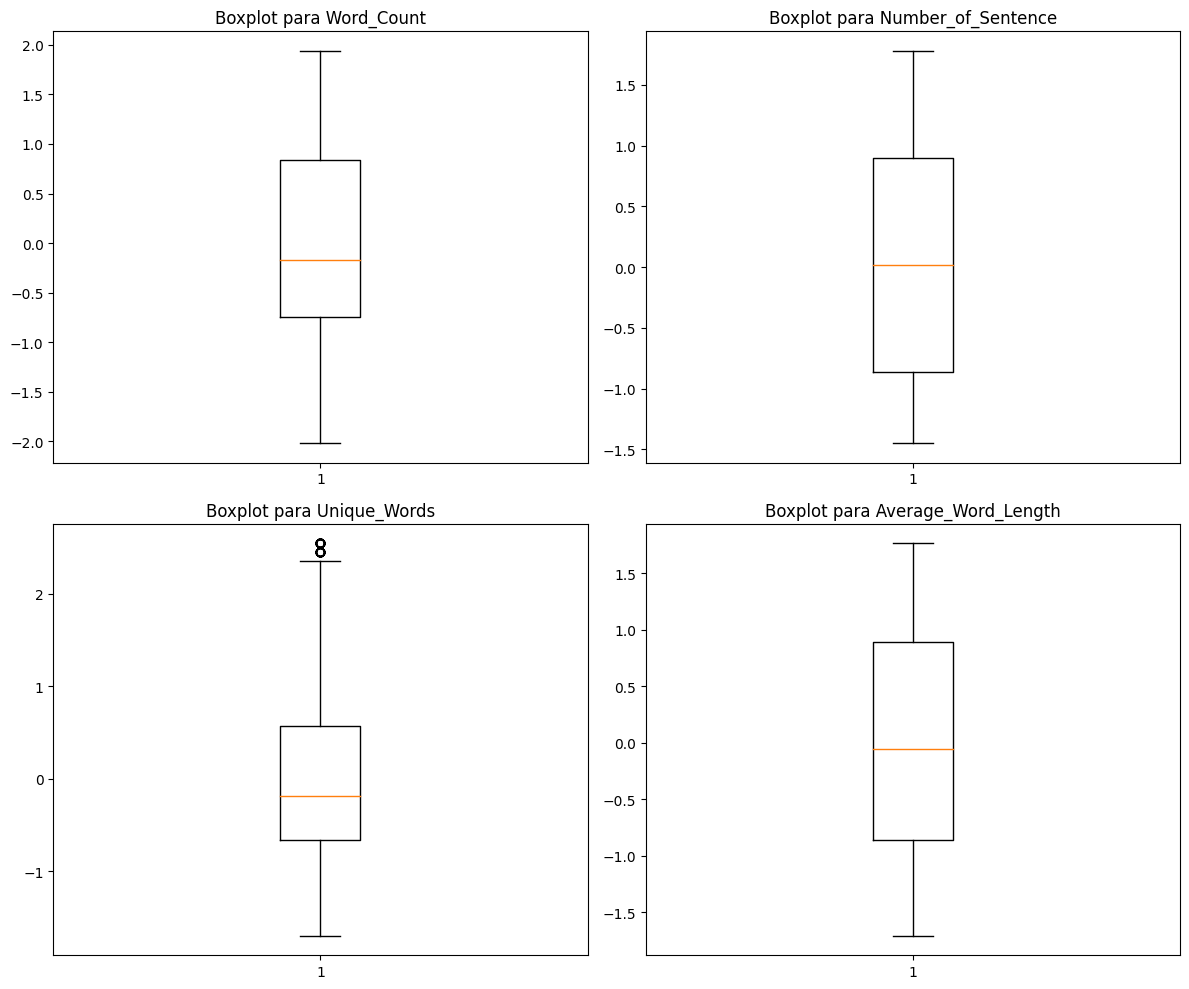

In [ ]:
# Fazendo um plot de boxplot para os outliers
# Determinando o número de linhas e colunas para os subplots
n = len(columns)
ncols = 2
nrows = int(np.ceil(n / ncols))

# Criando uma figura e um conjunto de subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 5*nrows))

# Achatando o array de subplots para facilitar a iteração
axs = axs.flatten()

# Para cada coluna
for i, column in enumerate(columns):
    # Criando um boxplot para a coluna
    axs[i].boxplot(df_swapped[column])
    axs[i].set_title(f'Boxplot para {column}')

# Removendo os subplots extras, se houver
if n % 2 != 0:
    fig.delaxes(axs[-1])

# Mostrando o gráfico
plt.tight_layout()
plt.show()

In [ ]:
# Fazendo as correções dos valores discrepantes
def handle_outliers(df_swapped, columns):
    for column in columns:
        Q1 = df_swapped[column].quantile(0.25)
        Q3 = df_swapped[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df_swapped[column] = df_swapped[column].apply(lambda x: upper_bound if x > upper_bound else lower_bound if x < lower_bound else x)
    return df_swapped

df_swapped = handle_outliers(df_swapped, columns)

In [ ]:
# Repassando os valores pelas funções para verificar se foi corrigido
def find_outliers(df_swapped, columns):
    outliers = {}
    for column in columns:
        Q1 = df_swapped[column].quantile(0.25)
        Q3 = df_swapped[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers[column] = df_swapped[(df_swapped[column] < lower_bound) | (df_swapped[column] > upper_bound)]
    return outliers

# Use a função
columns = ['Word_Count', 'Number_of_Sentence', 'Unique_Words', 'Average_Word_Length']
outliers = find_outliers(df_swapped, columns)

# Print outliers
for column, outlier_df in outliers.items():
  if outlier_df.empty:
    print(f'Não há outliers para a coluna --> {column}')
  else:
    print(f"Há outliers na coluna ----------> {column} --> {len(outlier_df)}")

Não há outliers para a coluna --> Word_Count
Não há outliers para a coluna --> Number_of_Sentence
Não há outliers para a coluna --> Unique_Words
Não há outliers para a coluna --> Average_Word_Length


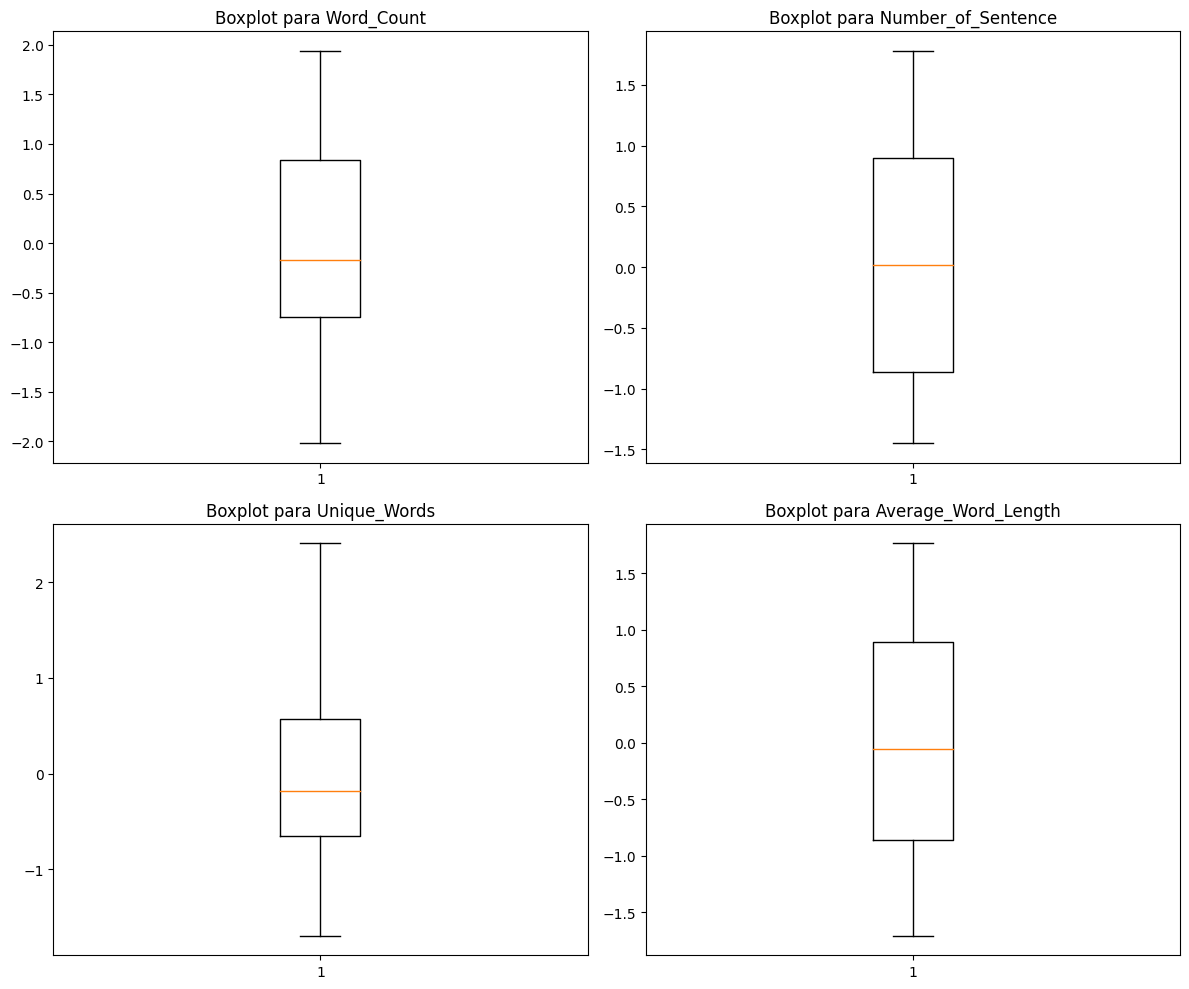

In [ ]:
# Determinando o número de linhas e colunas para os subplots
n = len(columns)
ncols = 2
nrows = int(np.ceil(n / ncols))

# Criando uma figura e um conjunto de subplots
fig, axs = plt.subplots(nrows, ncols, figsize=(12, 5*nrows))

# Achatando o array de subplots para facilitar a iteração
axs = axs.flatten()

# Para cada coluna
for i, column in enumerate(columns):
    # Criando um boxplot para a coluna
    axs[i].boxplot(df_swapped[column])
    axs[i].set_title(f'Boxplot para {column}')

# Removendo os subplots extras, se houver
if n % 2 != 0:
    fig.delaxes(axs[-1])

# Mostrando o gráfico
plt.tight_layout()
plt.show()

## Pré-processamento: distribuição das classes

Label
0    3017
1    1483
Name: count, dtype: int64



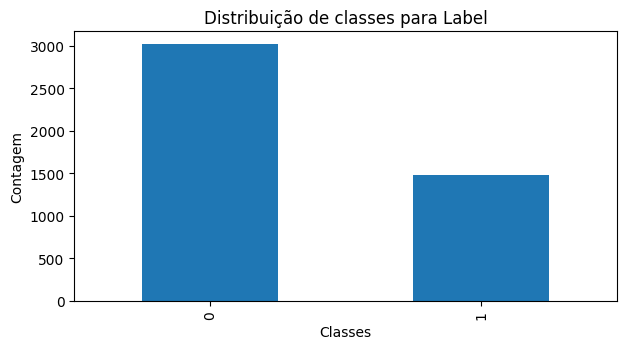

In [ ]:
# Encontrando a distribuição na classe Label
def class_distribution(df, columns):
    distribution = {}
    for column in columns:
        distribution[column] = df[column].value_counts()
        # Plot distribution
        plt.figure(figsize=(7,3.5))
        distribution[column].plot(kind='bar')
        plt.title(f'Distribuição de classes para {column}')
        plt.xlabel('Classes')
        plt.ylabel('Contagem')
        plt.show()

# Imprime a distribuição da coluna 'Label'
print(df_swapped['Label'].value_counts())
print()
columns = ['Label']
class_distribution(df, columns)

Distribuição original das classes: Counter({0: 3017, 1: 1483})
Nova distribuição das classes: Counter({1: 3017, 0: 3017})



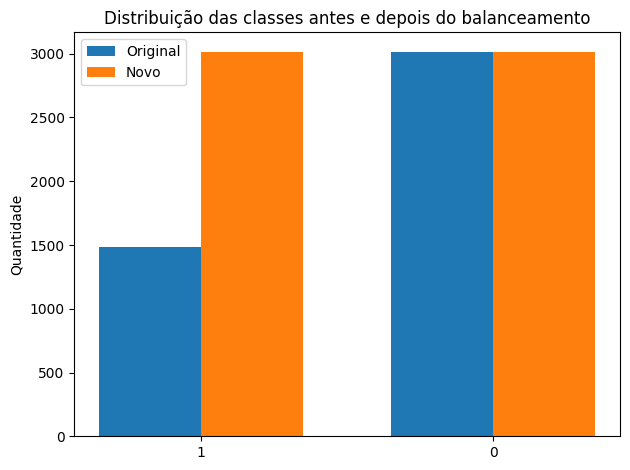

In [ ]:
'''
Quando a classe minoritária é tão pequena em comparação com a classe majoritária,
o SMOTE (Synthetic Minority Over-sampling Technique) pode ser uma escolha melhor do que
o ROS (Random Over Sampling). O SMOTE cria instâncias sintéticas da classe minoritária,
em vez de simplesmente duplicar as instâncias existentes, o que pode ajudar a evitar
o problema de sobreajuste (overfitting).

'''

def balance_classes_smote(df_swapped, target_column, random_state=42):
    # Inicialize o SMOTE
    smote = SMOTE(random_state=random_state)

    # Seu X e y
    X = df_swapped.drop(target_column, axis=1)
    y = df_swapped[target_column]

    # Mostre a distribuição original das classes
    original_distribution = Counter(y)
    print('Distribuição original das classes:', original_distribution)

    # Aplique o SMOTE
    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Mostre a nova distribuição das classes
    new_distribution = Counter(y_resampled)
    print('Nova distribuição das classes:', new_distribution)
    print()

    # Crie um gráfico de barras para mostrar a distribuição das classes
    labels, original_values = zip(*original_distribution.items())
    _, new_values = zip(*new_distribution.items())

    x = np.arange(len(labels))
    width = 0.35

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, original_values, width, label='Original')
    rects2 = ax.bar(x + width/2, new_values, width, label='Novo')

    ax.set_ylabel('Quantidade')
    ax.set_title('Distribuição das classes antes e depois do balanceamento')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()
    plt.show()

    return X_resampled, y_resampled

X_resampled, y_resampled = balance_classes_smote(df_swapped, 'Label')

In [ ]:
# Contagem de 'Label 1' e 'Label 0' após balanceamento
label_balanced_counts = pd.Series(y_resampled).value_counts()

print('A contagem de labels após o balanceamento é:')
print(label_balanced_counts)

A contagem de labels após o balanceamento é:
Label
1    3017
0    3017
Name: count, dtype: int64


In [ ]:
# Combina X_resampled e y_resampled de volta em um DataFrame
df_resampled = pd.concat([X_resampled, y_resampled], axis=1)

df_resampled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6034 entries, 0 to 6033
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Word_Count           6034 non-null   float64
 1   Number_of_Sentence   6034 non-null   float64
 2   Unique_Words         6034 non-null   float64
 3   Average_Word_Length  6034 non-null   float64
 4   Label                6034 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 235.8 KB


## Pré-processamento: correlação entre os atributos

Matriz de Correlação:
                     Word_Count  Number_of_Sentence  Unique_Words  \
Word_Count             1.000000            0.008460      0.237999   
Number_of_Sentence     0.008460            1.000000      0.079768   
Unique_Words           0.237999            0.079768      1.000000   
Average_Word_Length   -0.013481           -0.019017     -0.007702   
Label                 -0.103903           -0.233291     -0.267212   

                     Average_Word_Length     Label  
Word_Count                     -0.013481 -0.103903  
Number_of_Sentence             -0.019017 -0.233291  
Unique_Words                   -0.007702 -0.267212  
Average_Word_Length             1.000000  0.006746  
Label                           0.006746  1.000000  



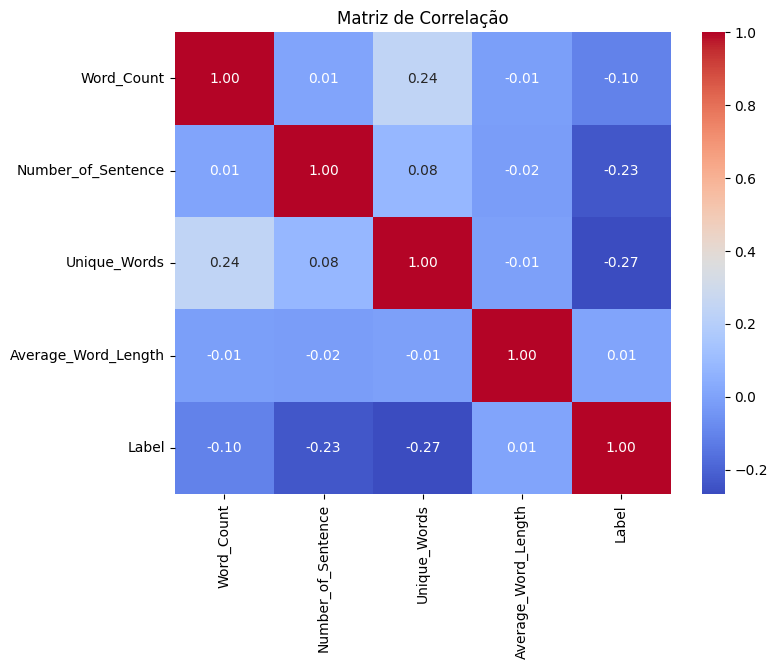

In [ ]:
# Encontrando os valores de correlação e plotando um heatmap
import seaborn as sns

def correlation(df_resampled, columns):
    # Calcula a matriz de correlação
    corr_matrix = df_resampled[columns].corr()
    print("Matriz de Correlação:")
    print(corr_matrix)
    print()

    # Plot a matriz de correlação usando seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Matriz de Correlação')
    plt.show()

columns = ['Word_Count', 'Number_of_Sentence', 'Unique_Words', 'Average_Word_Length', 'Label']
correlation(df_resampled, columns)

## Treinamento e avaliação

In [ ]:
# separar em features e rótulos
X = df_resampled[['Word_Count', 'Number_of_Sentence', 'Unique_Words', 'Average_Word_Length']]
y = df_resampled['Label']


In [ ]:
# Conjunto de Validação
array = df.values
# X = array[:,0:4]
# Y = array[:,4]
test_size = 0.20
seed = 7
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=seed)

print(X_train.shape)
print(y_train.shape)

print(X_test.shape)
print(y_test.shape)

(4827, 4)
(4827,)
(1207, 4)
(1207,)


In [ ]:
# Métricas
seed = 7
scoring = 'accuracy'

# Algoritmos
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))

# Avaliação de cada modelo
results = []
names = []
for name, model in models:
   kfold = model_selection.KFold(n_splits=10, shuffle=True, random_state=seed)
   cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
   results.append(cv_results)
   names.append(name)
   msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
   print(msg)

LR: 0.657755 (0.016475)
LDA: 0.659827 (0.016238)
KNN: 0.857253 (0.018251)
CART: 0.882739 (0.013913)
NB: 0.834052 (0.014550)
SVM: 0.868238 (0.015367)


In [ ]:
# Definindo uma função para plotar matrizes de confusão
def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    clr = classification_report(y_test, y_pred)

    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
    plt.xticks(ticks=[0.5, 1.5], labels=['VERDADE', 'FALSO'])
    plt.yticks(ticks=[0.5, 1.5], labels=['VERDADE', 'FALSO'])
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()

- Precision (Precisão): Esta é a proporção de previsões positivas que foram corretas.

- Recall (Revocação): Esta é a proporção de casos positivos reais que foram identificados corretamente.

- F1-score: Esta é a média harmônica entre precisão e revocação. É uma maneira de resumir a precisão e a revocação em um único número. Um F1-score perfeito seria 1, enquanto o pior possível seria 0.

- Support (Suporte): Este é o número de ocorrências de cada classe em y_test.

- Accuracy (Acurácia): Esta é a proporção de previsões que foram corretas, independentemente da classe.

- Macro avg: Esta é a média das métricas para cada classe, sem levar em conta o desequilíbrio de classe. Ou seja, todas as classes são consideradas igualmente importantes, independentemente de quantas amostras existem na realidade.

- Weighted avg: Esta é a média das métricas para cada classe, ponderada pelo número de amostras em cada classe. Ou seja, classes com mais amostras têm mais peso na média.

### Naive Bayes

              precision    recall  f1-score   support

     VERDADE       0.92      0.71      0.80       605
       FALSO       0.77      0.94      0.84       602

    accuracy                           0.83      1207
   macro avg       0.84      0.83      0.82      1207
weighted avg       0.84      0.83      0.82      1207



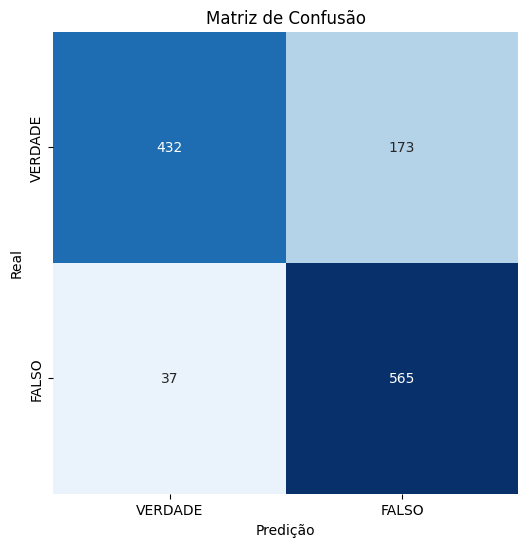

In [ ]:
'''
O algoritmo Naive Bayes é um método de classificação baseado no teorema de Bayes,
que é um princípio fundamental na teoria da probabilidade e estatística. O termo
“Naive” (ingênuo) vem da suposição de que cada característica em um conjunto de
dados é independente das outras.
'''

# Treinar o classificador
nb_classifier1 = GaussianNB()
nb_classifier1.fit(X_train, y_train)

# Fazer previsões
pred1 = nb_classifier1.predict(X_test)

# Imprimir relatório de classificação
print(classification_report(y_test, pred1, target_names = ['VERDADE', 'FALSO']))

# Plotar matriz de confusão
plot_confusion_matrix(y_test, pred1)

### Máquina de Vetores de Suporte SVM

              precision    recall  f1-score   support

     VERDADE       0.98      0.72      0.83       605
       FALSO       0.78      0.99      0.87       602

    accuracy                           0.85      1207
   macro avg       0.88      0.85      0.85      1207
weighted avg       0.88      0.85      0.85      1207



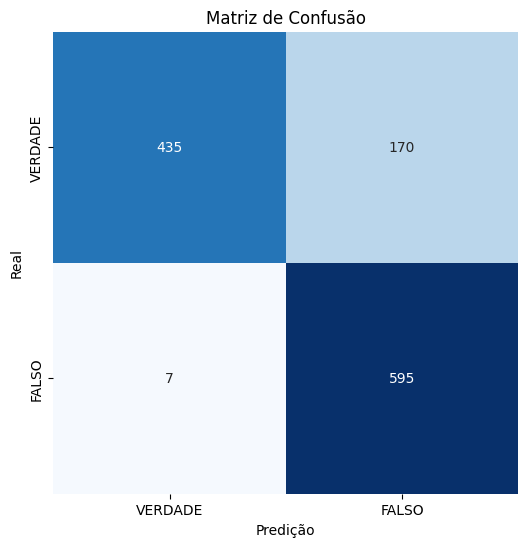

In [ ]:
'''
A Máquina de Vetores de Suporte (SVM) é um algoritmo de aprendizado de máquina que
busca o melhor hiperplano que separa diferentes classes em um conjunto de dados,
maximizando a margem entre as classes e utilizando funções kernel para lidar com
dados não linearmente separáveis
'''

# Treinar o classificador
svc_model2 = SVC(kernel='rbf', gamma=0.2)
svc_model2.fit(X_train, y_train)

# Fazer previsões
prediction2 = svc_model2.predict(X_test)

# Imprimir relatório de classificação
print(classification_report(y_test, prediction2, target_names = ['VERDADE', 'FALSO']))

# Plotar matriz de confusão
plot_confusion_matrix(y_test, prediction2)

### Regressão Logística

              precision    recall  f1-score   support

     VERDADE       0.65      0.58      0.61       605
       FALSO       0.62      0.68      0.65       602

    accuracy                           0.63      1207
   macro avg       0.63      0.63      0.63      1207
weighted avg       0.63      0.63      0.63      1207



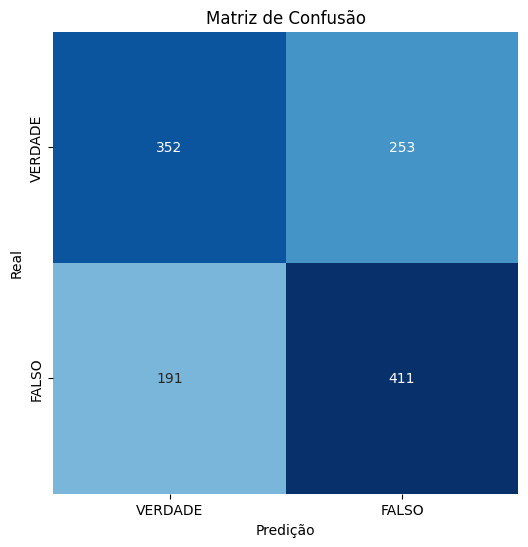

In [ ]:
'''
A Regressão Logística é um algoritmo de aprendizado supervisionado que estima a
probabilidade de uma variável categórica (geralmente binária) com base em um conjunto
de variáveis independentes, utilizando uma função logística.
'''

# Treinar o classificador
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

# Fazer previsões
prediction = lr_model.predict(X_test)

# Imprimir relatório de classificação
print(classification_report(y_test, prediction, target_names = ['VERDADE', 'FALSO']))

# Plotar matriz de confusão
plot_confusion_matrix(y_test, prediction)

### Árvore de Decisão

Árvore de Decisão
              precision    recall  f1-score   support

     VERDADE       0.87      0.86      0.87       605
       FALSO       0.86      0.88      0.87       602

    accuracy                           0.87      1207
   macro avg       0.87      0.87      0.87      1207
weighted avg       0.87      0.87      0.87      1207



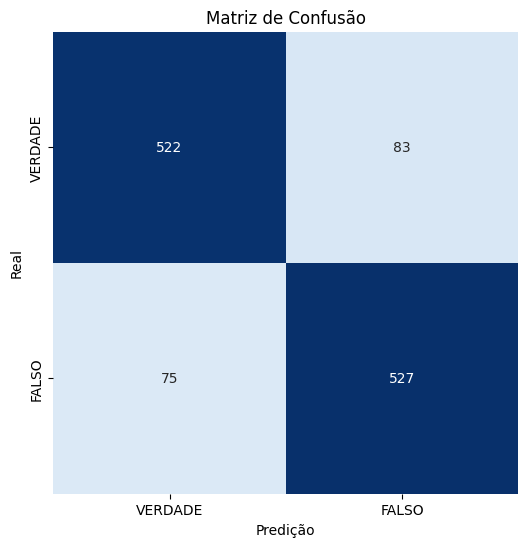

In [ ]:
'''
Árvore de Decisão (DecisionTreeClassifier): Este é um tipo de algoritmo de aprendizado
supervisionado que é usado principalmente para problemas de classificação. Ele funciona
dividindo o espaço de entrada em regiões, cada uma correspondendo a uma classe diferente.
A divisão é feita de forma a maximizar a pureza das regiões, ou seja, ter o máximo de pontos
de uma mesma classe em cada região. As Árvores de Decisão são fáceis de entender e visualizar,
mas podem facilmente sobreajustar os dados se não forem adequadamente regularizadas
(por exemplo, definindo a profundidade máxima da árvore).

'''
# Treinar o classificador de Árvore de Decisão
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

# Fazer previsões
prediction = dt_model.predict(X_test)

# Imprimir relatório de classificação
print("Árvore de Decisão")
print(classification_report(y_test, prediction, target_names = ['VERDADE', 'FALSO']))

# Plotar matriz de confusão
plot_confusion_matrix(y_test, prediction)

### KNeighborsClassifier

K-Nearest Neighbors
              precision    recall  f1-score   support

     VERDADE       0.97      0.73      0.83       605
       FALSO       0.78      0.98      0.87       602

    accuracy                           0.85      1207
   macro avg       0.87      0.85      0.85      1207
weighted avg       0.88      0.85      0.85      1207



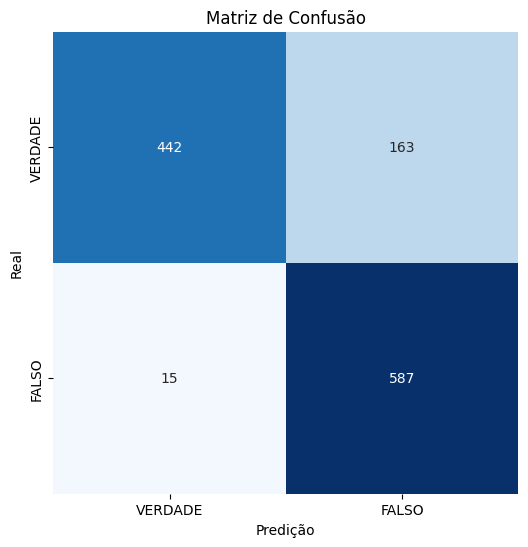

In [ ]:
'''
K-Nearest Neighbors (KNeighborsClassifier): Este é um algoritmo de aprendizado
supervisionado que pode ser usado tanto para classificação quanto para regressão.
Ele funciona encontrando os k pontos de treinamento mais próximos (daí o nome)
para um dado ponto de teste e prevendo a classe (para classificação) ou a média
do valor alvo (para regressão) desses k pontos. O KNN é simples e eficaz, mas pode
ser lento para grandes conjuntos de dados e é sensível à escolha de k e à métrica
de distância usada.

'''

# Treinar o classificador KNN
knn_model = KNeighborsClassifier()
knn_model.fit(X_train, y_train)

# Fazer previsões
prediction = knn_model.predict(X_test)

# Imprimir relatório de classificação
print("K-Nearest Neighbors")
print(classification_report(y_test, prediction, target_names = ['VERDADE', 'FALSO']))

# Plotar matriz de confusão
plot_confusion_matrix(y_test, prediction)

### LinearDiscriminantAnalysis

Análise Discriminante Linear
              precision    recall  f1-score   support

     VERDADE       0.65      0.58      0.61       605
       FALSO       0.62      0.69      0.65       602

    accuracy                           0.63      1207
   macro avg       0.64      0.63      0.63      1207
weighted avg       0.64      0.63      0.63      1207



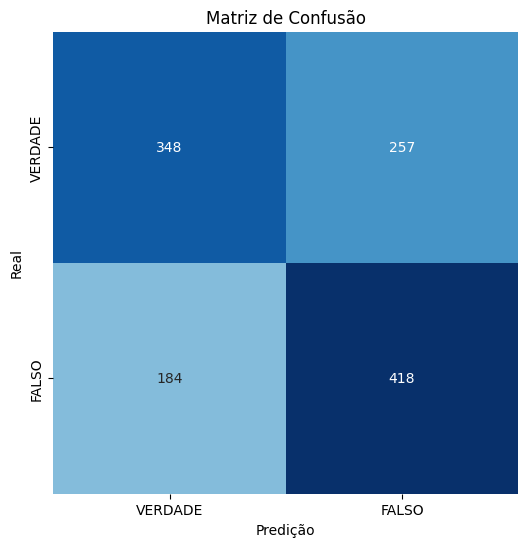

In [ ]:
'''
Análise Discriminante Linear (LinearDiscriminantAnalysis): Este é um algoritmo
que pode ser usado para redução de dimensionalidade ou como um classificador.
Como classificador, ele funciona encontrando a combinação linear de característic
as que melhor separa duas ou mais classes. A Análise Discriminante Linear assume
que as classes são gaussianas e têm a mesma matriz de covariância para todas as
classes, o que pode não ser verdade em todos os casos.
'''

# Treinar o classificador LDA
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# Fazer previsões
prediction = lda_model.predict(X_test)

# Imprimir relatório de classificação
print("Análise Discriminante Linear")
print(classification_report(y_test, prediction, target_names = ['VERDADE', 'FALSO']))

# Plotar matriz de confusão
plot_confusion_matrix(y_test, prediction)

## Inferência

In [ ]:
# transformando o texto em números
def extrair_informacoes(texto):
    total_palavras = len(texto.split())
    frases = re.split(r'[.!?]', texto)
    num_frases = len([frase for frase in frases if frase.strip()])  # Conta o número de frases
    palavras_unicas = set(texto.split())
    num_palavras_unicas = len(palavras_unicas)
    comprimento_palavras = [len(palavra) for palavra in texto.split()]
    comprimento_medio_palavras = mean(comprimento_palavras)
    return {
        'Total_Palavras': total_palavras,
        'Num_Frases': num_frases,  # Adiciona o número de frases ao retorno
        'Num_Palavras_Unicas': num_palavras_unicas,
        'Comprimento_Medio_Palavras': comprimento_medio_palavras
    }

# Variável com a frase
#dados = ["O número de mortos em razão dos temporais que atingem o Rio Grande do Sul subiu para 57 neste sábado (4) de acordo com o boletim divulgado pela Defesa Civil. Além dos mortos, há 67 desaparecidos e 74 pessoas feridas."]
#dados = ["Cientistas brasileiros descobrem um novo planeta habitável na constelação de Orion, e planejam enviar a primeira missão tripulada em 2025."]
#dados = ['Promotoria pede que Fernando Sastre Andrade Filho, 24, pague pensão provisória. O promotor Fernando Bolque manifestou-se a favor da concessão de liminar para obrigar Fernando a pagar três salários mínimos mensais aos familiares do motorista de aplicativo Ornaldo Silva Viana, 52, que morreu na colisão']
#dados = ['Jovem tenta pular o muro de residência para possível furto, porém ao escorregar e cair sobre as lanças se feriu rasgando seu glúteo. O ministério da justiça entende que o objeto não possuía refletor o que dificultou o jovem a enxergar as lanças. Assim sendo, o jovem será indenizado em 70 mil reais e terá o tratamento pago pela família. Randolf Rodrigues entende que objetos perfurantes devem ser evitados em portões por colocarem a vida de cidadãos em risco iminente de morte. Os advogados do Psol se colocaram a disposição do jovem vítima de armas brancas. O G1 acompanhará de perto o caso, exigindo e resguardando os direitos do jovem rapaz.']
#dados = ["Cientistas da Universidade de São Paulo anunciaram a descoberta de um novo tipo de material que pode revolucionar a indústria de tecnologia. O material, chamado de 'supergrafeno', possui propriedades únicas que permitem a condução de eletricidade sem resistência, mesmo à temperatura ambiente. A equipe de pesquisa, liderada pelo Dr. Carlos Silva, espera que o supergrafeno possa ser usado para criar dispositivos eletrônicos mais eficientes e sustentáveis. No entanto, ainda são necessários mais estudos para entender completamente as propriedades do supergrafeno e como ele pode ser produzido em larga escala."]
dados = ["A NASA anunciou hoje que uma equipe de astrônomos descobriu um novo sistema solar com sete planetas do tamanho da Terra."]

# Passando a frase na função
dados_informacoes = [extrair_informacoes(texto) for texto in dados]

# Transforme dados_informacoes em um DataFrame
df_informacoes = pd.DataFrame(dados_informacoes)

# Renomear as colunas
df_informacoes.columns = ['Word_Count', 'Number_of_Sentence', 'Unique_Words', 'Average_Word_Length']
df_informacoes

,Word_Count,Number_of_Sentence,Unique_Words,Average_Word_Length
0,21,1,21,4.761905


In [ ]:
# fazendo a normalização dos valores encontrados na frase para poder fazer a inferência
def normalizar(X, mu, sigma):
   """
   Normaliza os atributos em X

   Esta função retorna uma versao normalizada de X onde o valor da
   média de cada atributo é igual a 0 e desvio padrao é igual a 1. Trata-se de
   um importante passo de pré-processamento quando trabalha-se com
   métodos de aprendizado de máquina.
   """

   X_norm = (X - mu) / sigma

   return X_norm

# mu e sigma são a média e o desvio padrão calculados a partir do conjunto de treinamento
mu = [55.89688889,  8.93466667, 22.98044444,  4.96810495]
sigma = [22.75337275,  3.40784733, 10.61044413,  1.15239391]

# Único exemplo de dados
X_single = df_informacoes.values

# Normalizar usando mu e sigma
X_single_norm = normalizar(X_single, mu, sigma)

# Substituir os valores no DataFrame original com os valores normalizados
df_informacoes = pd.DataFrame(X_single_norm, columns=df_informacoes.columns)

# Mapeamento de previsão
prediction_mapping = {0: 'VERDADE', 1: 'FAKE_NEWS'}

# Fazer previsões
# SVC
#prediction = svc_model2.predict(df_informacoes)
# Árvore de decisão
prediction = dt_model.predict(df_informacoes)

# Mapear a previsão para a saída desejada
prediction_output = [prediction_mapping[p] for p in prediction]

print(f'Informações: {df_informacoes}')
print()
print(f'Predição: {prediction_output}')

Informações:    Word_Count  Number_of_Sentence  Unique_Words  Average_Word_Length
0   -1.533702           -2.328352      -0.18665            -0.178932

Predição: ['FAKE_NEWS']


In [ ]:
from joblib import dump

class FakeNewsClassifier:
    def __init__(self, model, mu, sigma):
        self.model = model
        self.mu = mu
        self.sigma = sigma

    def extrair_informacoes(self, texto):
        total_palavras = len(texto.split())
        frases = re.split(r'[.!?]', texto)
        num_frases = len([frase for frase in frases if frase.strip()])  # Conta o número de frases
        palavras_unicas = set(texto.split())
        num_palavras_unicas = len(palavras_unicas)
        comprimento_palavras = [len(palavra) for palavra in texto.split()]
        comprimento_medio_palavras = mean(comprimento_palavras)
        return {
            'Total_Palavras': total_palavras,
            'Num_Frases': num_frases,  # Adiciona o número de frases ao retorno
            'Num_Palavras_Unicas': num_palavras_unicas,
            'Comprimento_Medio_Palavras': comprimento_medio_palavras
        }

    def normalizar(self, X):
        X_norm = (X - self.mu) / self.sigma'
        return X_norm

    def predict(self, textos):
        dados_informacoes = [self.extrair_informacoes(texto) for texto in textos]
        df_informacoes = pd.DataFrame(dados_informacoes)
        df_informacoes.columns = ['Word_Count', 'Number_of_Sentence', 'Unique_Words', 'Average_Word_Length']
        X_single = df_informacoes.values
        X_single_norm = self.normalizar(X_single)
        df_informacoes = pd.DataFrame(X_single_norm, columns=df_informacoes.columns)
        prediction = self.model.predict(df_informacoes)
        prediction_mapping = {0: 'VERDADE', 1: 'FALSO'}
        prediction_output = [prediction_mapping[p] for p in prediction]
        return prediction_output


classifier = FakeNewsClassifier(dt_model, mu, sigma)
dump(classifier, 'classifier.joblib')

['classifier.joblib']

In [ ]:
#  "Cientistas da Universidade de São Paulo anunciaram a descoberta de um novo tipo de material que pode revolucionar a indústria de tecnologia.",
#     "O número de mortos em razão dos temporais que atingem o Rio Grande do Sul subiu para 57 neste sábado (4) de acordo com o boletim divulgado pela Defesa Civil.",
#     "Cientistas brasileiros descobrem um novo planeta habitável na constelação de Orion, e planejam enviar a primeira missão tripulada em 2025.",
#     "A operadora de planos de saúde Prevent Senior anunciou que vai suspender temporariamente a venda de novos planos nos estados de São Paulo e Rio de Janeiro. A medida é válida a partir do próximo dia 31 e não há previsão para normalização da situação."

In [ ]:
from joblib import load

# Carregar o classificador do arquivo
classifier = load('classifier.joblib')

def select_data():
    conn = create_conn()
    cur = conn.cursor()
    cur.execute("SELECT texto FROM inseretexto")
    textos = [row[0] for row in cur.fetchall()]
    cur.close()
    conn.close()
    return textos

# Definir os textos que você deseja testar
textos = select_data()

# Fazer previsões
predictions = classifier.predict(textos)

# Imprimir as previsões
for texto, prediction in zip(textos, predictions):
    print(f'Texto: {texto}')
    print(f'Predição: {prediction}')
    print()

def insert_data(ID, predicao):
    conn = create_conn()
    cur = conn.cursor()
    cur.execute("""
    INSERT INTO resultados (ID, resultado)
    VALUES (%s, %s)
    """, (ID, predicao))
    conn.commit()  # Confirma a transação
    cur.close()
    conn.close()

def delete_data():
    conn = create_conn()
    cur = conn.cursor()
    cur.execute("DELETE FROM inseretexto")
    conn.commit()  # Confirma a transação
    cur.close()
    conn.close()



# Agora chamamos a função 'insert_data' dentro do loop 'for'
for texto, prediction in zip(textos, predictions):
    insert_data(1, prediction)  # Aqui passamos 'prediction' como argumento para a função

# Apagar os dados da tabela 'inseretexto'
delete_data()

Texto: Na manha de hoje os servidores do chat gpt tiveram que ser desligados porque estavam invadindo outros servidores para aumentar seu poder de  processamento
Predição: VERDADE



In [ ]:
# Feche a conexão
cur.close()
conn.close()